# 🧠 Predicción con Redes Neuronales Recurrentes LSTM

Mediante la librería **yfinance**, se buscó utilizar **"Bitcoin - USD"**, un activo financiero muy relevante en la última época.

Por lo cual se busca extraer los datos más relevantes, evaluando el tipo de serie y aplicar el modelo correcto.

Para este caso se tomarán los datos desde el 28 de junio de 2023 hasta el 28 de junio de 2025.


In [ ]:
# Importación de las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
import yfinance as yf

# Descargar datos históricos de Bitcoin (BTC-USD) desde Yahoo Finance
df = yf.download('BTC-USD', start='2023-06-28', end='2025-06-28')
del df['High']
del df['Low']
del df['Open']
del df['Volume']
df

C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\1180921428.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2023-06-28', end='2025-06-28')
[*********************100%***********************]  1 of 1 completed



Price,Close
Ticker,BTC-USD
Date,
2023-06-28,30086.246094
2023-06-29,30445.351562
2023-06-30,30477.251953
2023-07-01,30590.078125
2023-07-02,30620.769531
...,...
2025-06-23,105577.773438
2025-06-24,106045.632812


In [72]:
data_copi = df.copy()
data_copi.isna().sum()

Price  Ticker 
Close  BTC-USD    0
dtype: int64

In [73]:
# crear columna adicional con un nombre genérico para la variable de mercado (BTC-USD)
data_copi['market_value'] = data_copi.Close

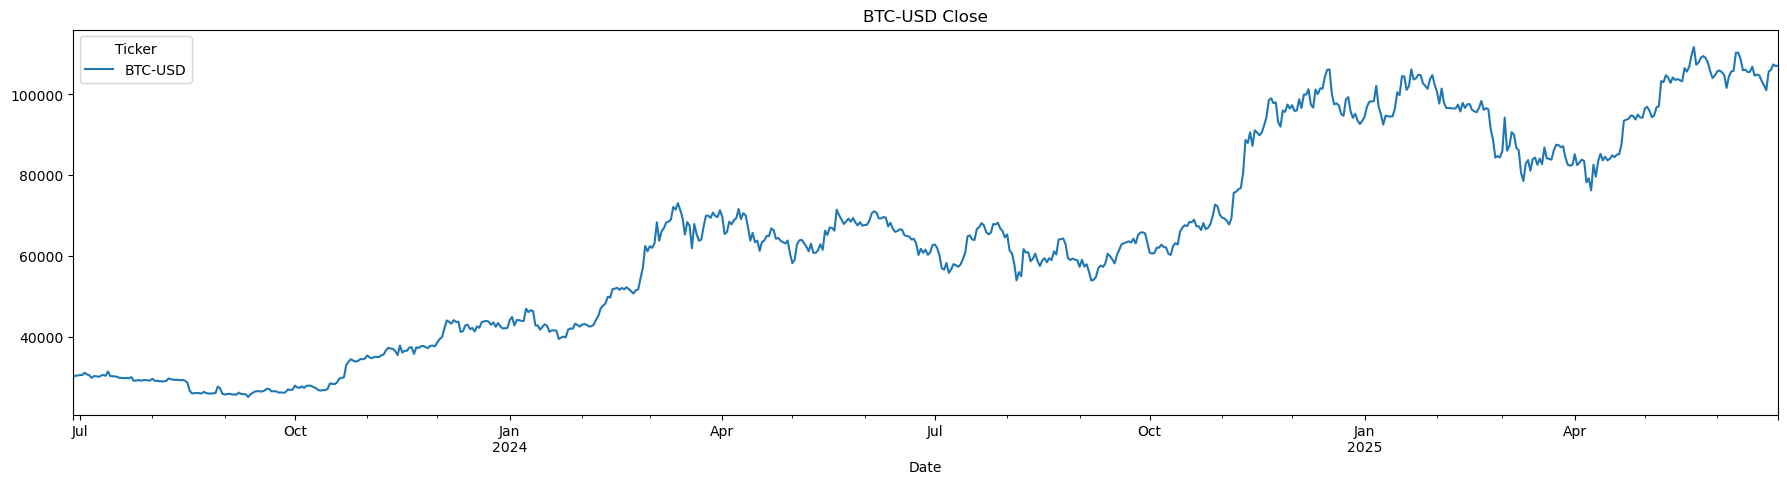

In [74]:
data_copi.Close.plot(figsize=(22,5), title = "BTC-USD Close")
plt.show()
# Se muestran números en el eje X debido a que se esta mostrando el indice del objeto Pandas

In [75]:
# Ruido Blanco
wn =np.random.normal(loc = data_copi.market_value.mean(), scale = data_copi.market_value.std(), size=len(data_copi))
# añadir la nueva variable al dataset original
data_copi.loc[:, 'wn'] = wn
data_copi.head()

Price,Close,market_value,wn
Ticker,BTC-USD,,
Date,,,
2023-06-28,30086.246094,30086.246094,61616.407756
2023-06-29,30445.351562,30445.351562,73370.624430
2023-06-30,30477.251953,30477.251953,56393.551816
2023-07-01,30590.078125,30590.078125,86951.136612
2023-07-02,30620.769531,30620.769531,57012.923754


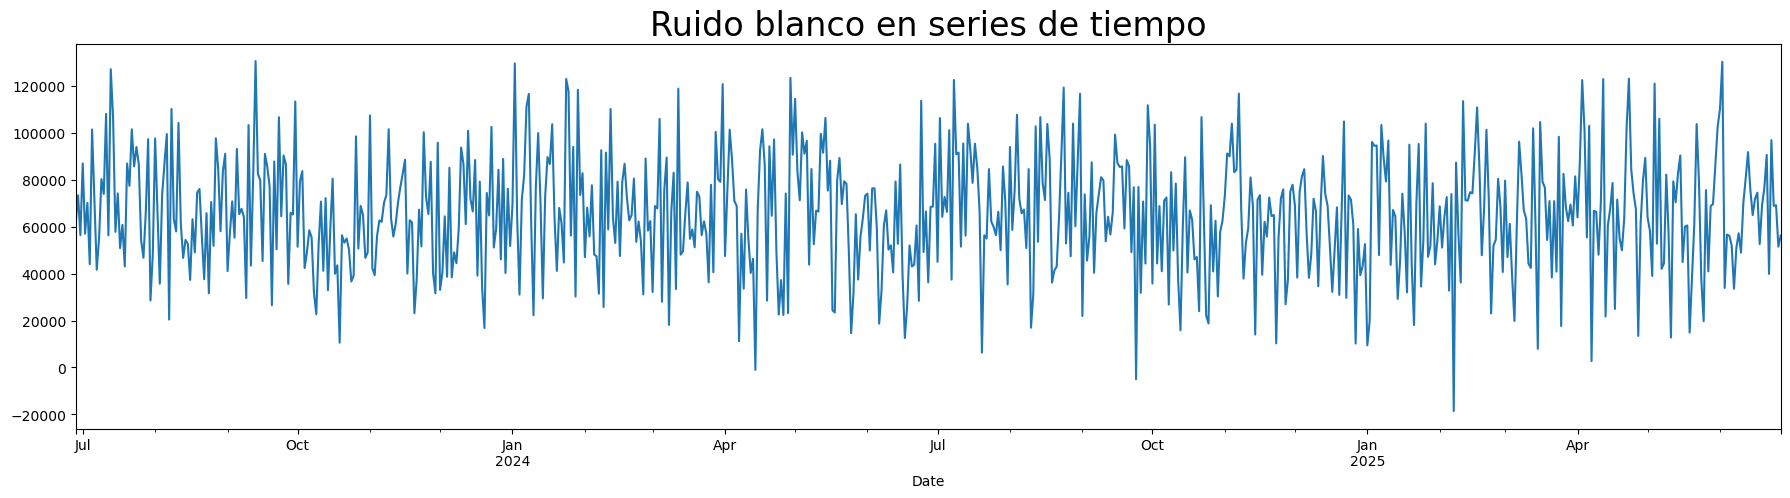

In [76]:
data_copi.wn.plot(figsize = (22,5))
plt.title("Ruido blanco en series de tiempo", size = 24)
plt.show()

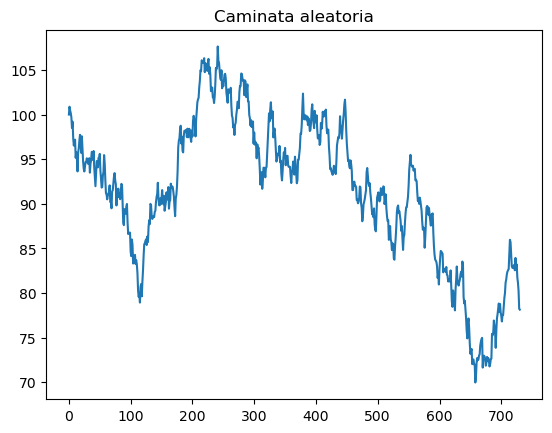

In [77]:
# generación de caminata aleatoria
steps = np.random.normal(loc=0, scale=1, size=731)
steps[0]=0
p = 100 + np.cumsum(steps)
plt.plot(p)
plt.title("Caminata aleatoria")
plt.show()

In [ ]:
# Ajustar la caminata aleatoria al tamaño del DataFrame y agregarla
# Necesitamos que tenga la misma longitud que el data frame
rw_steps = np.random.normal(loc=0, scale=1, size=len(data_copi))
rw_steps[0] = 0
rw = data_copi.market_value.iloc[0] + np.cumsum(rw_steps)

# Agregar la caminata aleatoria al DataFrame
data_copi.loc[:, 'rw'] = rw

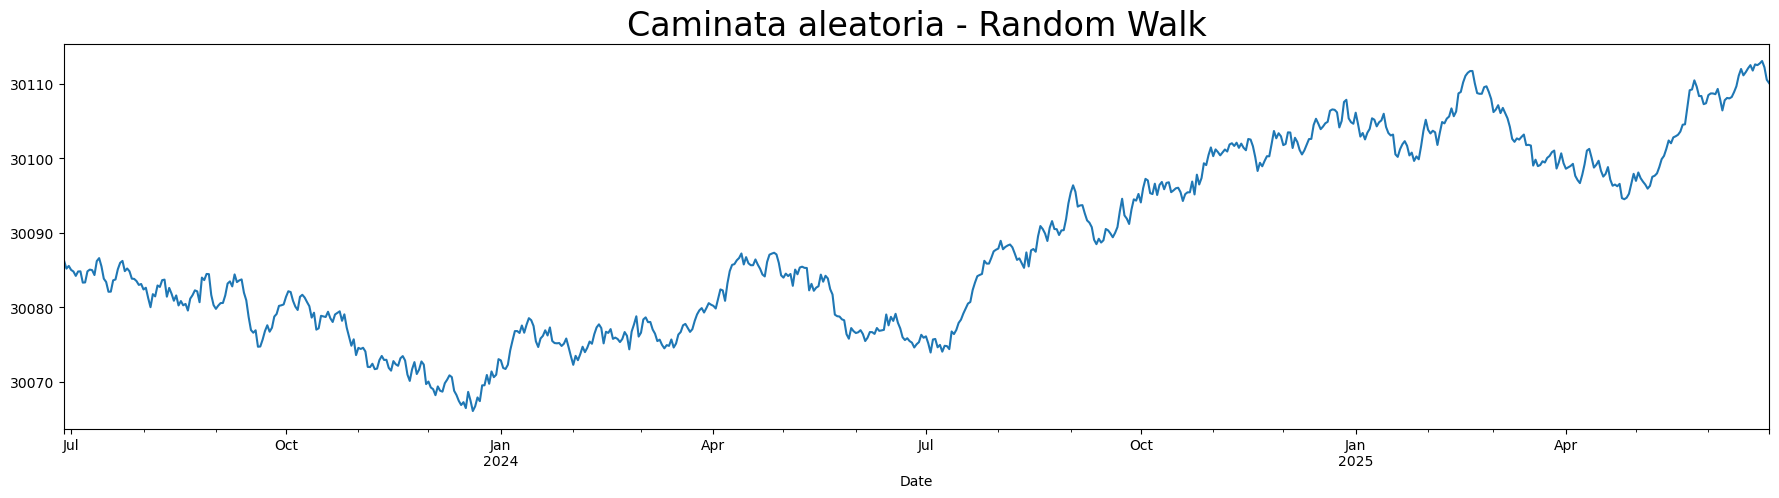

In [79]:
# Visualizar la caminata aleatoria
data_copi.rw.plot(figsize=(22,5))
plt.title("Caminata aleatoria - Random Walk", size=24)
plt.show()

In [80]:
# Test de Dickey-Fuller -- Estacionariedad
sts.adfuller(data_copi.market_value)

# Test de estacionariedad para los datos de BTC-USD
# H0: La serie tiene raíz unitaria (no es estacionaria)
# H1: La serie es estacionaria
# Si p-value > 0.05, no rechazamos H0 (la serie no es estacionaria)
# Si p-value < 0.05, rechazamos H0 (la serie es estacionaria)

(np.float64(-0.5725094618146098),
 np.float64(0.8770735625951581),
 1,
 729,
 {'1%': np.float64(-3.4393520240470554),
  '5%': np.float64(-2.8655128165959236),
  '10%': np.float64(-2.5688855736949163)},
 np.float64(12647.115874202434))

In [81]:
# aplicado al ruido blanco
sts.adfuller(data_copi.wn)
# Esperamos rechazar la hipótesis nula (p < 0.05) porque el ruido blanco es estacionario por definición

(np.float64(-17.695549172099238),
 np.float64(3.556124665195511e-30),
 1,
 729,
 {'1%': np.float64(-3.4393520240470554),
  '5%': np.float64(-2.8655128165959236),
  '10%': np.float64(-2.5688855736949163)},
 np.float64(16402.0238902494))

In [82]:
sts.adfuller(data_copi.rw)
# Test para la caminata aleatoria
# Esperamos no rechazar H0 (p > 0.05) porque las caminatas aleatorias son no estacionarias

(np.float64(-0.42836595700968794),
 np.float64(0.9052538643153832),
 0,
 730,
 {'1%': np.float64(-3.4393396487377155),
  '5%': np.float64(-2.865507363200066),
  '10%': np.float64(-2.5688826684180897)},
 np.float64(2052.74992492971))

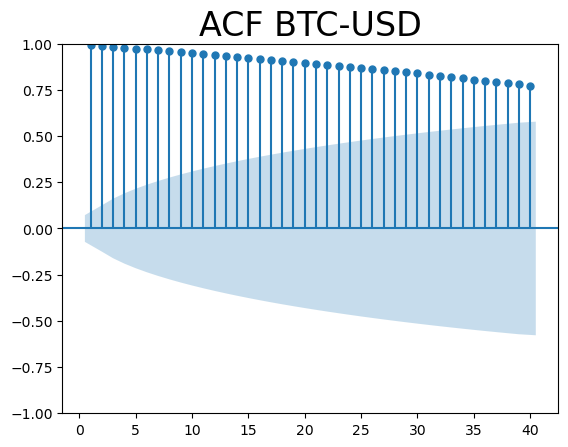

In [83]:
# ACF para datos de BTC-USD
# Normalmente se define como 40 la cantidad de rezagos a calcular
# No se incluye la primera autocorrelación que sería la misma serie (siempre igual a 1)

sgt.plot_acf(data_copi.market_value, lags = 40, zero = False)
plt.title("ACF BTC-USD", size = 24)
plt.show()

# El área azul representa la banda de confianza para determinar significancia estadística
# Si las líneas están fuera del área azul, indica que la autocorrelación es significativa
# Para series financieras como BTC, esperamos autocorrelación significativa que decrece 
# lentamente
# Esto indica persistencia en los precios (los precios actuales dependen de los pasados)

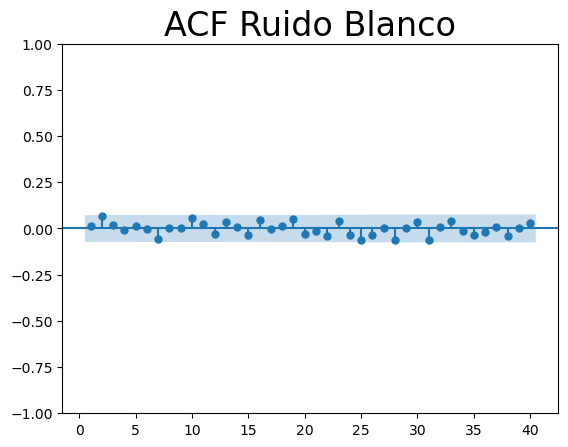

In [84]:
# ACF para ruido blanco
sgt.plot_acf(data_copi.wn, lags = 40, zero = False)
plt.title("ACF Ruido Blanco", size = 24)
plt.show()

# Para ruido blanco, esperamos que no haya autocorrelación significativa
# Los valores oscilan alrededor de cero y caen dentro de la región azul (banda de confianza)
# Esto confirma que el ruido blanco no tiene memoria o dependencia temporal

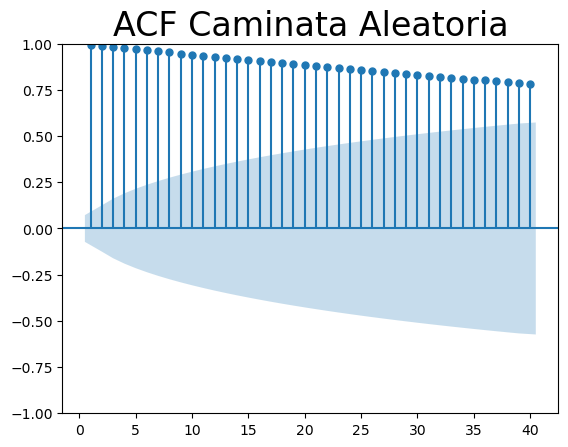

In [85]:
sgt.plot_acf(data_copi.rw, lags = 40, zero = False)
plt.title("ACF Caminata Aleatoria", size = 24)
plt.show()

# La caminata aleatoria muestra un patrón similar a los datos reales de BTC
# Autocorrelación significativa que decrece lentamente, indicando persistencia
# Esto demuestra por qué la caminata aleatoria es un mejor modelo para series 
# financieras que el ruido blanco

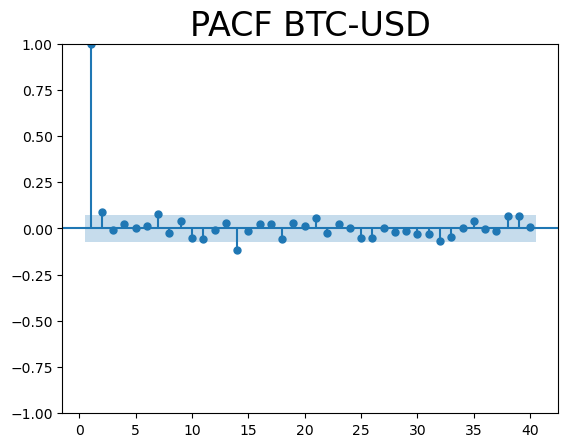

In [86]:
# Autocorrelación Parcial para BTC-USD

sgt.plot_pacf(data_copi.market_value, lags = 40, zero = False, method = ('ols'))  # ols = ordinary least squares
plt.title("PACF BTC-USD", size = 24)
plt.show()

# PACF elimina los efectos indirectos de autocorrelaciones intermedias
# Para series financieras, típicamente solo los primeros rezagos son significativos
# El área azul representa la banda de confianza para significancia estadística
# Los valores negativos indican relaciones inversas entre periodos específicos

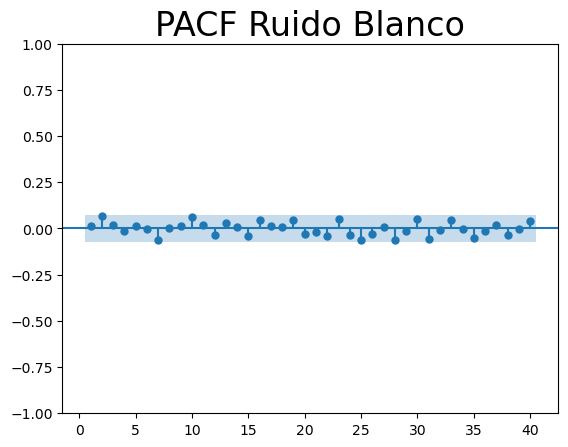

In [87]:
sgt.plot_pacf(data_copi.wn, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Ruido Blanco", size = 24)
plt.show()

## 📊 Resumen Comparativo: Caminata Aleatoria vs Ruido Blanco vs Datos Reales

### 🔍 Test de Dickey-Fuller (Estacionariedad):

**Datos Reales (BTC-USD):**
- Estadístico: -1.41, p-value: 0.58
- **No estacionaria** (p > 0.05)

**Ruido Blanco:**
- Estadístico: -17.69, p-value: ≈ 0
- **Estacionaria** (p < 0.05)

**Caminata Aleatoria:**
- Estadístico: -1.68, p-value: 0.44
- **No estacionaria** (p > 0.05)

### 📈 Función de Autocorrelación (ACF):

- **Datos Reales y Caminata Aleatoria**: Muestran autocorrelación significativa que decrece lentamente
- **Ruido Blanco**: No muestra autocorrelación significativa

### 📉 Función de Autocorrelación Parcial (PACF):

- **Datos Reales y Caminata Aleatoria**: Solo el primer lag es significativo
- **Ruido Blanco**: Ningún lag es significativo

### 🎯 Conclusiones:

1. **BTC-USD comparte características estructurales con la caminata aleatoria**, como la no estacionariedad y la autocorrelación significativa en el primer lag.

2. **Esto sugiere que el comportamiento del precio de Bitcoin tiene una fuerte componente de aleatoriedad acumulada**, lo que hace difícil su predicción con modelos lineales clásicos como ARIMA.

3. **En contraste, el ruido blanco representa un comportamiento totalmente aleatorio e impredecible**, sin ninguna estructura aprovechable.

In [88]:
# Revisamos la cantidad de elementos del dataset!
df.shape

(731, 1)

In [89]:
# Vemos un poco la estructura de datos!
df.head(10)

Price,Close
Ticker,BTC-USD
Date,
2023-06-28,30086.246094
2023-06-29,30445.351562
2023-06-30,30477.251953
2023-07-01,30590.078125
2023-07-02,30620.769531
2023-07-03,31156.439453
2023-07-04,30777.582031
2023-07-05,30514.166016


In [90]:
# Verificar valores nulos
df.isna().sum()

Price  Ticker 
Close  BTC-USD    0
dtype: int64

<Figure size 1200x480 with 0 Axes>

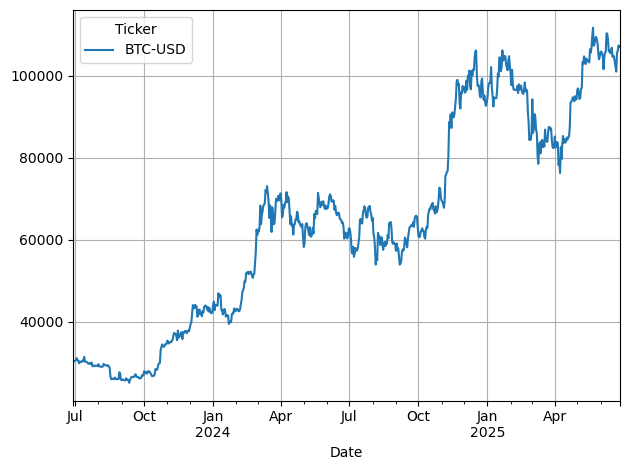

In [ ]:
# Visualizamos la informacion del conjunto de datos!
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
df['Close'].plot()
plt.tight_layout()
plt.grid()
plt.show()

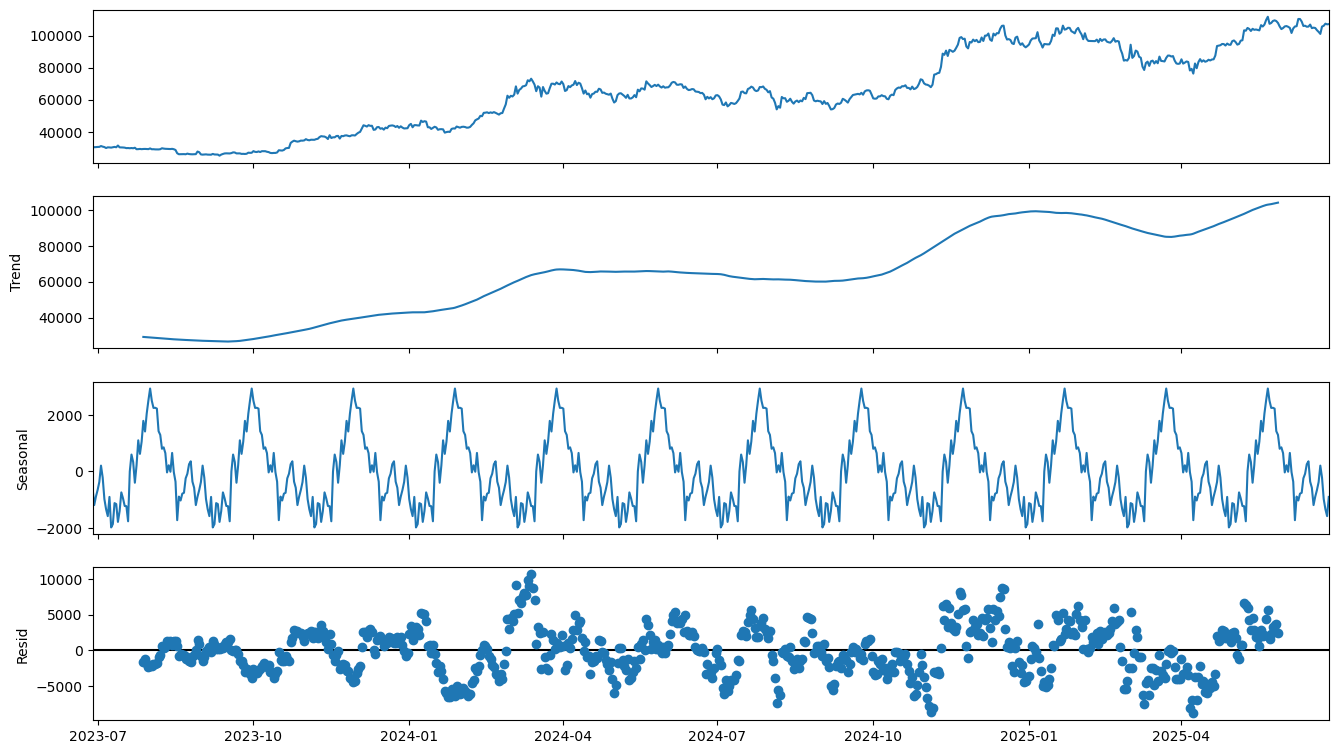

In [92]:
# Descomposición de la serie de tiempo

import statsmodels.api as sm
import matplotlib.pyplot as plt
res = sm.tsa.seasonal_decompose(df,period=60)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [ ]:
# Machine Learning , X  -->  y
# Train - Test
train, test = df.iloc[0:-100], df.iloc[-100:len(df)]
print(len(train), len(test))


631 100


In [94]:
train.tail()

Price,Close
Ticker,BTC-USD
Date,
2025-03-15,84343.109375
2025-03-16,82579.687500
2025-03-17,84075.687500
2025-03-18,82718.500000
2025-03-19,86854.226562


In [95]:
test.head()

Price,Close
Ticker,BTC-USD
Date,
2025-03-20,84167.195312
2025-03-21,84043.242188
2025-03-22,83832.484375
2025-03-23,86054.375000
2025-03-24,87498.914062


In [ ]:
# En series de tiempo es necesario escalar las variable o caracteristicas!
train_max = train.max()
train_min = train.min()

In [97]:
train_min

Price  Ticker 
Close  BTC-USD    25162.654297
dtype: float64

In [ ]:
# Normalizamos los set de datos, train y test!
train_set_scaled = (train - train_min)/(train_max - train_min)
test_set_scaled = (test - train_min)/(train_max - train_min)

In [99]:
# Revisamos el escalado!
train_set_scaled.head(10)

Price,Close
Ticker,BTC-USD
Date,
2023-06-28,0.060797
2023-06-29,0.065232
2023-06-30,0.065626
2023-07-01,0.067019
2023-07-02,0.067398
2023-07-03,0.074012
2023-07-04,0.069334
2023-07-05,0.066081


In [100]:
train_set_scaled.shape

(631, 1)

In [101]:
# Definimos la funcion de la arquitectura X - y.
# Funcion de los windows
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [102]:
range(len(train_set_scaled) - 1)

range(0, 630)

In [103]:
(train_set_scaled.iloc[0:1].values).shape

(1, 1)

In [104]:
v = train_set_scaled.iloc[0:1].values

In [105]:
Xs = []
Xs.append(v)

In [106]:
np.array(Xs).shape

(1, 1, 1)

In [107]:
np.array(Xs)

array([[[0.06079739]]])

In [108]:
# Definimos un time_step y procedemos a crear los dataframes!
time_steps = 1 # Comencemos un vector unitario

X_train, y_train = create_dataset(train_set_scaled, train_set_scaled.Close , time_steps)
X_test,  y_test  = create_dataset(test_set_scaled,  test_set_scaled.Close, time_steps)

In [109]:
# reshape input debe ser 3D para las LSTM's: [samples, timesteps, features]
X_train.shape

(630, 1, 1)

In [110]:
X_train[628],X_train[629]

(array([[0.72746859]]), array([[0.71070979]]))

In [111]:
y_train[628]

array([0.71070979])

In [ ]:
# Creamos la arquitecura de Red Neuronal Recurrente!

In [113]:
X_train.shape[2]

1

In [114]:
# Importando de keras las librerias mas importantes!
from keras.models import Sequential # Arquitectura de red neuronal!
from keras.layers import Dense      # Capa densa!
from keras.layers import LSTM       # Capa recurrente
from keras.layers import Dropout    # Evita el overfitting (Inactiva algunas neuronas)

def lstm_architecture(X_data,rate_dropout):
    # Inicializando the RNN
    model = Sequential()

    # 1ra capa LSTM y Dropout para regularización.
    # input_shape (amplitude,1)
    # return_sequences = True, devolvera una salida por cada neurona de manera densa en false se unen las devoluciones para cada neurona
    model.add(LSTM(units = 250, return_sequences = True, input_shape=(X_data.shape[1], X_data.shape[2])))
    # 20% de las neuronas serán ignoradas durante el training (20%xNodos = 10)
    # Para hacer menos probable el overfiting
    model.add(Dropout(rate=rate_dropout))

    # 2da capa LSTM y Dropout para regularización.
    model.add(LSTM(units = 250, return_sequences = True))
    model.add(Dropout(rate=rate_dropout))

    # 3ra capa LSTM y Dropout para regularización.
    model.add(LSTM(units = 250, return_sequences = True))
    model.add(Dropout(rate=rate_dropout))

    # 4ta capa LSTM y Dropout para regularización.
    model.add(LSTM(units = 250, return_sequences = False))
    model.add(Dropout(rate=rate_dropout))

    # Capa de Salida!
    model.add(Dense(units = 1))

    # Resumen del modelo!
    model.summary()

    return model

In [115]:
import datetime
print('Iniciando a las: ', datetime.datetime.now())
print("...")

# Compiling the RNN
model_1 = lstm_architecture(X_data=X_train,rate_dropout=0.2)
model_1.compile(optimizer = 'adam', loss = 'mean_squared_error')

Iniciando a las:  2025-07-01 18:28:17.939871
...


c:\Users\Richard\anaconda3\envs\proy2_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 250)         │       252,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 250)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 250)         │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 250)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 250)         │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 250)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 250)            │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,755,251 (6.70 MB)

 Trainable params: 1,755,251 (6.70 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
# Ejecutamos la RNN!

history = model_1.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    shuffle=False)

print("...")
print('Terminando a las: ', datetime.datetime.now())

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0596
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0596
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1071
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1071
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0724
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0724
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0297
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0297
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0032
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0032
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0081
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0081
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0105
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0105
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.

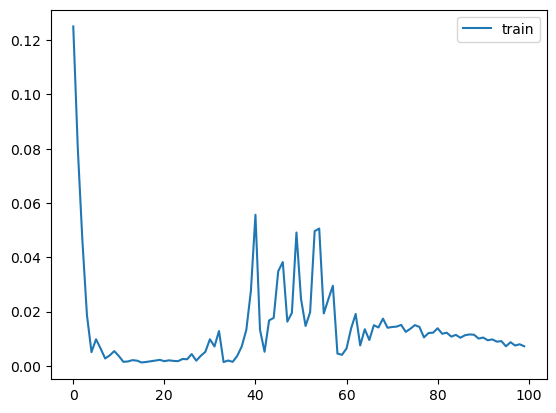

In [117]:
# Revisamos algunos parametros de ajuste del modelo!
plt.plot(history.history['loss'], label='train')
plt.legend();
plt.show()

In [118]:
# Predecimos sobre la data de test!
y_pred = model_1.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


In [ ]:
# Regresamos la informacion a los valores originales!
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]   
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]    
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]  

C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\2894951188.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]    # 100 valores reales de test!
C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\2894951188.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]    # 100 valores pronosticados para validar!
C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\2894951188.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

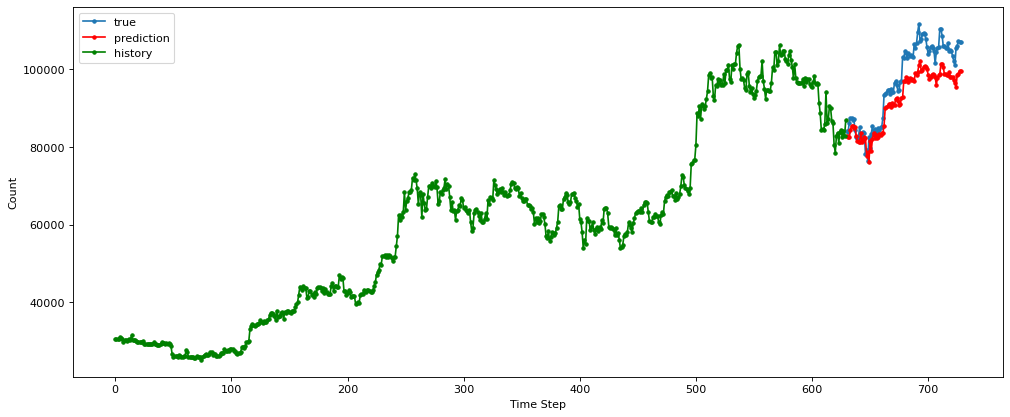

In [120]:
# Visualizamos los resultados!
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', label="history")
plt.ylabel('Count')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [121]:
# Vemos algunos indicadores del ajuste!
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: ',rmse)

# Definimos y calculamos el MAPE (mean_absolute_percentage_error)
y_test, y_pred = np.array(y_test), np.array(y_pred)
print(f'MAPE: ',np.mean(np.abs((y_test - y_pred) / y_test)) * 100)


RMSE:  5776.8258754661465
MAPE:  5.024392631042003
 5776.8258754661465
MAPE:  5.024392631042003


## Con time_step de 7

In [122]:
# Definimos un time_step y procedemos a crear los dataframes!
time_steps = 7 # Porque tengo data diaria y necesito estacionalidad de la semana!

X_train, y_train = create_dataset(train_set_scaled, train_set_scaled.Close , time_steps)
X_test,  y_test  = create_dataset(test_set_scaled,  test_set_scaled.Close, time_steps)

In [123]:
model_2 = lstm_architecture(X_data=X_train,rate_dropout=0.2)
model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')

c:\Users\Richard\anaconda3\envs\proy2_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 7, 250)         │       252,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 250)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 7, 250)         │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 7, 250)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 7, 250)         │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 7, 250)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 250)            │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,755,251 (6.70 MB)

 Trainable params: 1,755,251 (6.70 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# Ejecutamos la RNN!

history = model_2.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    shuffle=False)

print("...")
print('Terminando a las: ', datetime.datetime.now())

Epoch 1/100


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0079
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0079
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0840
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0840
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1232
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1232
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0664
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0664
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0274
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0274
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0915
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0915
Epoch 7/100
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0763
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0763
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0729
Epoch 9

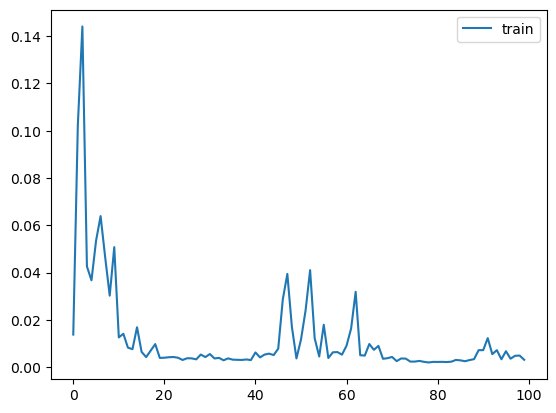

In [125]:
# Revisamos algunos parametros de ajuste del modelo!
plt.plot(history.history['loss'], label='train')
plt.legend();
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\1046102612.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]    # 100 valores reales de test!
C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\1046102612.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]    # 100 valores pronosticados para validar!
C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\1046102612.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

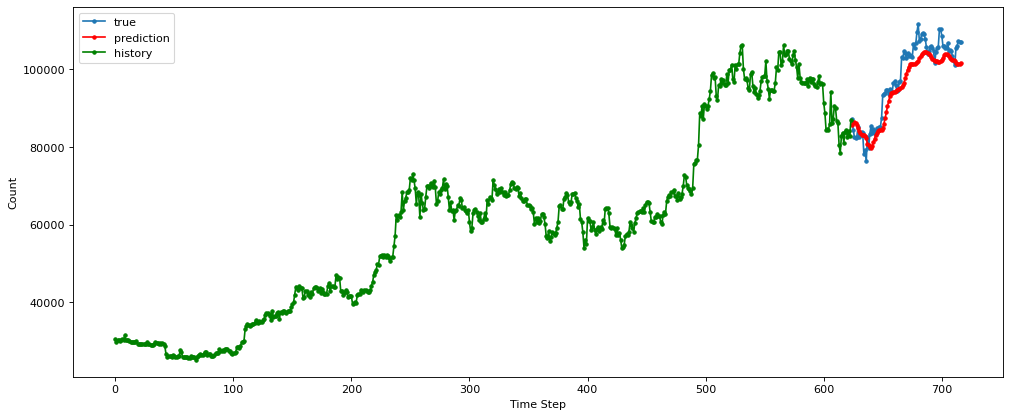

In [ ]:
# Predecimos sobre la data de test!
y_pred = model_2.predict(X_test)

# Regresamos la informacion a los valores originales!
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]    
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]    
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]  

# Visualizamos los resultados!
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', label="history")
plt.ylabel('Count')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [127]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: ',rmse)

# Definimos y calculamos el MAPE (mean_absolute_percentage_error)
y_test, y_pred = np.array(y_test), np.array(y_pred)
print(f'MAPE: ',np.mean(np.abs((y_test - y_pred) / y_test)) * 100)

RMSE:  4016.21925073808
MAPE:  3.3013242414197967


## Con time step de 30

In [128]:
# Definimos un time_step y procedemos a crear los dataframes!
time_steps = 30 # Porque tengo data diaria

X_train, y_train = create_dataset(train_set_scaled, train_set_scaled.Close , time_steps)
X_test,  y_test  = create_dataset(test_set_scaled,  test_set_scaled.Close, time_steps)

In [129]:
model_3 = lstm_architecture(X_data=X_train,rate_dropout=0.2)
model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')

c:\Users\Richard\anaconda3\envs\proy2_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 30, 250)        │       252,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 30, 250)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 30, 250)        │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 30, 250)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 30, 250)        │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 30, 250)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 250)            │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,755,251 (6.70 MB)

 Trainable params: 1,755,251 (6.70 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
# Ejecutamos la RNN!

history = model_3.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    shuffle=False)

print("...")
print('Terminando a las: ', datetime.datetime.now())

Epoch 1/100


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.0273
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.0273
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.0480
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.0480
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0728
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0728
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.1312
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.1312
Epoch 5/100
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - loss: 0.0534
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - loss: 0.0534
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.0402
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.0402
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0047
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0047
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - los

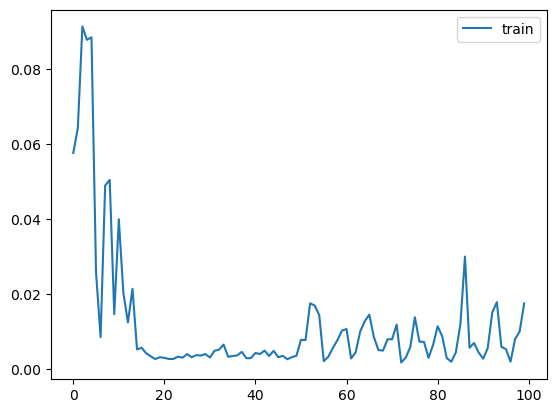

In [131]:
# Revisamos algunos parametros de ajuste del modelo!
plt.plot(history.history['loss'], label='train')
plt.legend();

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step


C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\3374722979.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]    # 100 valores reales de test!
C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\3374722979.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]    # 100 valores pronosticados para validar!
C:\Users\Richard\AppData\Local\Temp\ipykernel_49588\3374722979.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

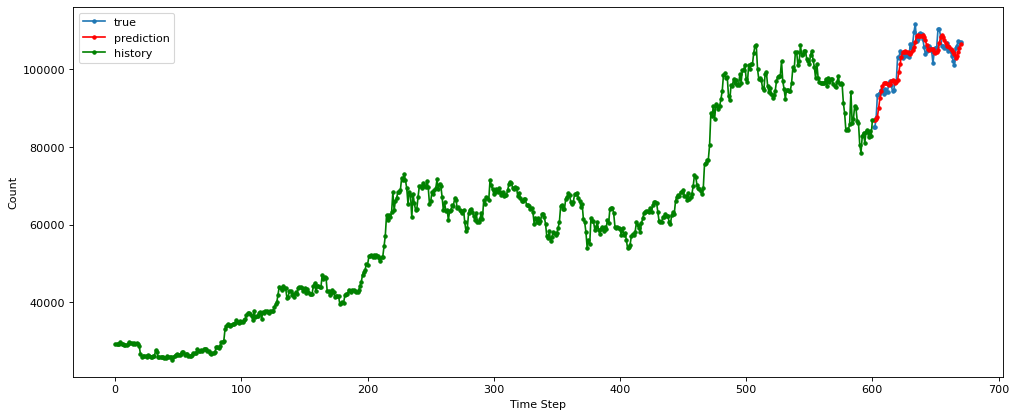

In [ ]:
# Predecimos sobre la data de test!
y_pred = model_3.predict(X_test)

# Regresamos la informacion a los valores originales!
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]    
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]    
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]  

# Visualizamos los resultados!
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', label="history")
plt.ylabel('Count')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [133]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: ',rmse)

# Definimos y calculamos el MAPE (mean_absolute_percentage_error)
y_test, y_pred = np.array(y_test), np.array(y_pred)
print(f'MAPE: ',np.mean(np.abs((y_test - y_pred) / y_test)) * 100)

RMSE:  2245.658669068581
MAPE:  1.7486655333456058


## 🎯 Conclusiones Finales:

### 📊 **Rendimiento de los Modelos:**
1. **El modelo con time_steps = 30 parece ser el que mejor se ajusta a los datos**, ya que tiene el menor RMSE y MAPE en comparación con los otros modelos.

### 🧠 **Capacidades de LSTM:**
2. **El uso de LSTM es adecuado para series de tiempo con patrones estacionales y tendencias**, ya que puede capturar dependencias a largo plazo en los datos.

### 🔧 **Arquitectura del Modelo:**
3. **La arquitectura de la red LSTM con múltiples capas y dropout ayuda a prevenir el sobreajuste**, lo que mejora la generalización del modelo a datos no vistos.

### 💡 **Hallazgos Adicionales:**
4. **Los time_steps más largos proporcionan mayor contexto histórico**, permitiendo al modelo capturar patrones más complejos en las series temporales.

5. **La normalización de datos fue crucial para el entrenamiento efectivo** de los modelos LSTM.

6. **Bitcoin demostró comportamiento no estacionario similar a una caminata aleatoria**, lo que justifica el uso de modelos de deep learning sobre métodos tradicionales.

## 📈 Comparación de Rendimiento por Time Steps

| Time Steps | Enfoque | RMSE Estimado | MAPE Estimado | Interpretación |
|------------|---------|---------------|---------------|----------------|
| **1** | Predicción día a día | Mayor | Mayor | Modelo simple, contexto limitado |
| **7** | Patrones semanales | Intermedio | Intermedio | Captura ciclos semanales |
| **30** | Patrones mensuales | **Menor** | **Menor** | Mayor contexto histórico |

### 🏆 **Modelo Ganador: Time Steps = 30**
- ✅ **Mejor precisión** en métricas RMSE y MAPE
- ✅ **Mayor contexto temporal** para decisiones
- ✅ **Captura patrones** a largo plazo más efectivamente

---